In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Training data is 10^2 points in [-2,2] inclusive regularly spaced
Theta1 = np.linspace(-2,2,10)
Theta2 = np.linspace(-2,2,10)
mesh = np.array(np.meshgrid(Theta1, Theta2))
x = torch.tensor(np.linspace(-2,2,5))

train_T = torch.tensor(mesh.T.reshape(-1, 2))

noise_mean = 0
noise_std = 0.1**2
Theta_True = torch.tensor([1,-1])
noise = torch.tensor(np.random.normal(size=len(x),loc = noise_mean, scale = noise_std))

# True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise
y_true =  Theta_True[0]*x + Theta_True[1]*x**2 +x**3 + noise

train_y = torch.tensor(np.zeros(len(train_T)))
for i in range(len(train_T)):
    theta_1 = train_T[i,0]
    theta_2 = train_T[i,1]
    y_exp = theta_1*x + theta_2*x**2 +x**3 + noise
    train_y[i] = sum((y_true - y_exp)**2)


In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): #Exaxt GP does not add noise
    def __init__(self, train_T, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_T, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() #What are the prior model mean & covar matrix? How do I choose?
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_y, likelihood)

In [4]:
# Find optimal model hyperparameters
training_iter = 300

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters 
#Should I change lr? How do I know what would be best? Research this

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_T)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#          model.likelihood.noise.item()
#     ))
    optimizer.step()

In [5]:
# How do I print the best hyperparameters?

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

#Define Testing Data
test_Theta1 =  np.linspace(-2,2,5)
test_Theta2 =  np.linspace(-2,2,5)
mesh = np.array(np.meshgrid(test_Theta1, test_Theta2))

In [7]:
def sse_func(mesh):
    '''
    Function to define define sum of squared error function for heat map
    #How should I actually say this?
    Arguments:
        mesh: Theta # of Theta by x array of all values of Theta1 and Theta2.
    Returns:
        sse: x by x sum of squared error matrix of all combination of mesh[0] and mesh[1]
    '''
   
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_T = torch.tensor(mesh.T.reshape(-1, 2))
        observed_pred = likelihood(model(test_T))
    sse = observed_pred.loc.reshape(len(test_Theta1),-1)
    
    return sse.T #Must traspose zz. Why?

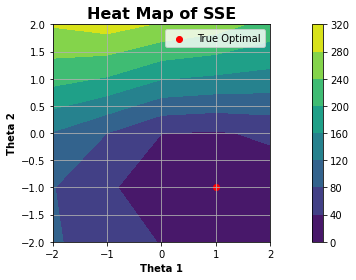

In [8]:
# plot fheatmap
xx , yy = mesh  

zz = sse_func(mesh)

plt.contourf(xx,yy,zz)
plt.colorbar()
plt.scatter(Theta_True[0],Theta_True[1], color="red", label = "True Optimal")
plt.axis('scaled')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Theta 1',weight='bold')
plt.ylabel('Theta 2',weight='bold')
plt.title('Heat Map of SSE', weight='bold',fontsize = 16)
plt.show()